In [25]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from jax import random, jit

import jax.numpy as jnp
import numpy as np

In [2]:
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)

In [37]:
def sample_n01(key,N):
    D = 2
    return random.normal(key, (N, D))

def log_prob_n01(x):
    return jnp.sum(-jnp.square(x)/2 - jnp.log(jnp.sqrt(2*jnp.pi)),axis=-1)

In [32]:
def nvp_forward(net_params, shift_and_log_scale_fn, x, flip=False):
    
    d = x.shape[-1]//2
    x1, x2 = x[:, :d], x[:, d:]
    if flip:
        x2, x1 = x1, x2
        
    shift, log_scale = shift_and_log_scale_fn(net_params, x1)
    y2 = x2*jnp.exp(log_scale) + shift
    
    if flip:
        x1, y2 = y2, x1
    y = jnp.concatenate([x1, y2], axis=-1)
    return y

In [33]:
def nvp_inverse(net_params, shift_and_log_scale_fn, y, flip=False):
    d = y.shape[-1]//2
    y1, y2 = y[:, :d], y[:, d:]
    
    if flip:
        y1, y2 = y2, y1
    
    shift, log_scale = shift_and_log_scale_fn(net_params, y1)
    x2 = (y2-shift)*jnp.exp(-log_scale)
    
    if flip:
        y1, x2 = x2, y1
    
    x = jnp.concatenate([y1, x2], axis=-1)
    return x, log_scale

In [30]:
def sample_nvp(net_params, shift_log_scale_fn, base_sample_fn, N, flip=False):
    x = base_sample_fn(N)
    return nvp_forward(net_params, shift_log_scale_fn, x, flip=flip)

def log_prob_nvp(net_params, shift_log_scale_fn, base_log_prob_fn, y, flip=False):
    x, log_scale = nvp_inverse(net_params, shift_log_scale_fn, y, flip=flip)
    ildj = -jnp.sum(log_scale, axis=-1)
    return base_log_prob_fn(x) + ildj

In [9]:
from jax.experimental import stax # neural network library
from jax.experimental.stax import Dense, Relu # neural network layers

In [15]:
def init_nvp(key):
    D = 2
    net_init, net_apply = stax.serial(
        Dense(512), Relu, Dense(512), Relu, Dense(D))
    in_shape = (-1, D//2)
    out_shape, net_params = net_init(key, in_shape)
    
    def shift_and_log_scale_fn(net_params, x1):
        s = net_apply(net_params, x1)
        return np.split(s, 2, axis=1)
    
    return net_params, shift_and_log_scale_fn

In [21]:
def init_nvp_chain(keys):
    flip = False
    ps, configs = [], []
    for key in keys:
        p, f = init_nvp(key)
        ps.append(p), configs.append((f, flip))
        flip = not flip
    return ps, configs

def sample_nvp_chain(ps, configs, base_sample_fn, N):
    x = base_sample_fn(N)
    for p, config in zip(ps, configs):
        shift_log_scale_fn, flip = config
        x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    return x

def make_log_prob_fn(p, log_prob_fn, config):
    shift_log_scale_fn, flip = config
    return lambda x: log_prob_nvp(p, shift_log_scale_fn, log_prob_fn, x, flip=flip)

def log_prob_nvp_chain(ps, configs, base_log_prob_fn, y):
    log_prob_fn = base_log_prob_fn
    for p, config in zip(ps, configs):
        log_prob_fn = make_log_prob_fn(p, log_prob_fn, config)
    return log_prob_fn(y)

In [26]:
from jax.experimental import optimizers
from jax import jit, grad
import numpy as onp

key = random.PRNGKey(0)

*subkeys, key = random.split(key,5)

ps, cs = init_nvp_chain(subkeys)

def loss(params, batch):
    return -jnp.mean(log_prob_nvp_chain(params, cs, log_prob_n01, batch))

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4)

In [38]:
@jit
def step(i, opt_state, batch):
    params = get_params(opt_state)
    g = grad(loss)(params, batch)
    return opt_update(i, g, opt_state)

iters = int(1e4)
data_generator = (X[np.random.choice(X.shape[0], 100)] for _ in range(iters))
opt_state = opt_init(ps)

for i in range(iters):
    opt_state = step(i, opt_state, next(data_generator))
    
ps = get_params(opt_state)

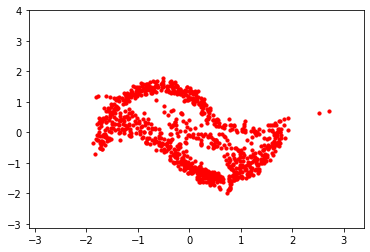

In [41]:
from matplotlib import animation, rc
from IPython.display import HTML, Image


key = random.PRNGKey(0)

x = sample_n01(key,1000)
values = [x]
for p, config in zip(ps, cs):
    shift_log_scale_fn, flip = config
    x = nvp_forward(p, shift_log_scale_fn, x, flip=flip)
    values.append(x)

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)

y = values[0]
paths = ax.scatter(y[:, 0], y[:, 1], s=10, color='red')

def animate(i):
    l = i//48
    t = (float(i%48))/48
    y = (1-t)*values[l] + t*values[l+1]
    paths.set_offsets(y)
    return (paths,)

anim = animation.FuncAnimation(fig, animate, frames=48*len(cs), interval=1, blit=False)
anim.save('anim.gif', writer='imagemagick', fps=60)